# data understanding of engineered features
This notebook takes care of the data understanding done on engineered features 

In [211]:
from os import path
import  pandas as pd
import seaborn 
import matplotlib.pyplot as plt
import numpy as np
ENGINEERED_RACES_PATH=path.join("..","dataset","engineered_races.csv")

The analysis is divided in three parts/comparisons:
- new vs old
- old vs old
- new vs new

first we extract the needed data.

In [212]:
races_df=pd.read_csv(ENGINEERED_RACES_PATH)
races_df['date']=pd.to_datetime(races_df['date'])


oldf_df=races_df[[        
        'points', 
        'length', 
        'climb_total', 
        'profile', 
        'startlist_quality',
        'position', 
        'cyclist_age', 
        'is_tarmac',
        'delta'
        ]]

newf_df=races_df[[
        'climbing_efficiency', 
        'competitive_age',
        'difficulty', 
        'convenience_score',
        'difficulty_score', 
        'performance_index',
        'gain_ratio'
        ]]
old_corr_data=oldf_df.corr()
new_corr_data=newf_df.corr()

on_corr_data=races_df[[
        'climbing_efficiency', 
        'competitive_age',
        'difficulty', 
        'convenience_score',
        'difficulty_score', 
        'performance_index',
        'gain_ratio',
        'points', 
        'length', 
        'climb_total', 
        'profile', 
        'startlist_quality',
        'position', 
        'cyclist_age', 
        'is_tarmac',
        'delta'
]].corr()

on_corr_data=on_corr_data.drop(columns=oldf_df.columns,index=newf_df.columns)




## old vs old features

<Axes: >

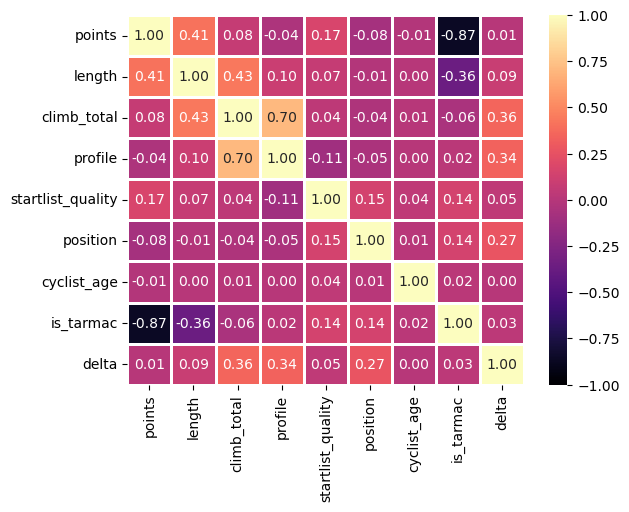

In [213]:
seaborn.heatmap(
    old_corr_data,
    annot=True, cmap='magma', vmin=-1, vmax=1, linewidths=1,fmt='.2f')

first length and delta are correlated which makes sense since longer tracks take more time to travel.

length and climb total are also highly related which makes snese given the fact that longer tracks require traveling thorugh longer steep parts .

profile and climb total is already explained.

is_tarmac has:
- a really negative coreraltion with points which is strange but could be explained with a very noise feature that so it's difficult to infer any acual relationship.
- a negative correltion with length which is difficult to explain but probvably also noise

delta has some interesting correlations:
- climb_total might make sense, since it might be explained by the fact that a high climb total might yield highh deltas, if we have a high climb total a racer will have to go through a lot of steep parts and keeping up with the pace of the race gets more difficult thus if the recer is left behind it is difficult recover w.r.t. to other types of tracks so it takes more time to reach the stage goal hence higher deltas.
- profile is strange, it might be coincidence given the encoding used for the profiles however if we stick to the logic behind the features engineering for terrain difficulty we observe taht profile encodings and the respective values maintain the same non de-crescent order meaning we get that higher profiles could be related to higher climb totals hence higher deltas. This also reinforces our theory on the mapping between profile encodings.



## new vs new features

<Axes: >

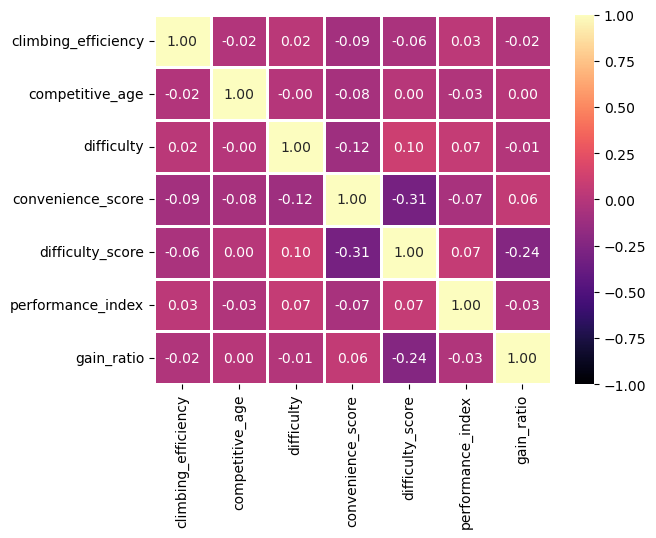

In [214]:
seaborn.heatmap(
    new_corr_data,
    annot=True, cmap='magma', vmin=-1, vmax=1, linewidths=1,fmt='.2f')

we can see no  real correlation aside from difficulty_score and convenience_score while we see the gain_ratio and difficulty_score also have negative correalation this makes sense sincea high_gain or convenience_score are related to a low difficulty.

## new vs old features

<Axes: >

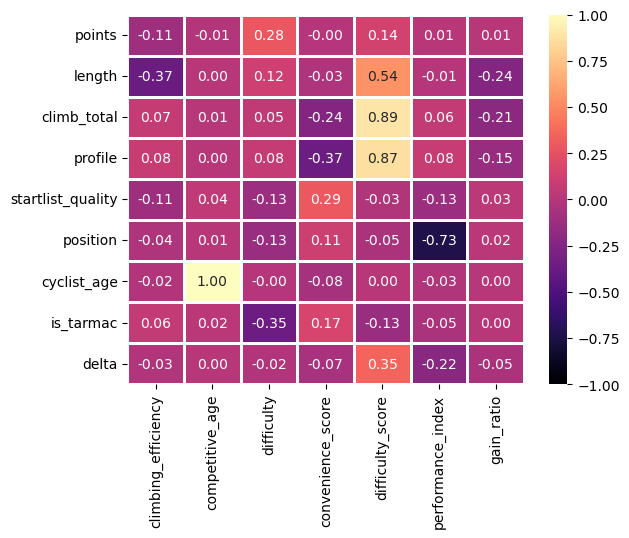

In [215]:
seaborn.heatmap(
    on_corr_data,
    annot=True, cmap='magma', vmin=-1, vmax=1, linewidths=1,fmt='.2f')

The difficulty score is of course  related to length, climb_total and profile since it is calculated using them however we see a correlation using delta which obvious given the correlation with how much time it takes to travel a difficult course whether it is due to steepness, high quotas or length.

Please note that the difficulty score is only related to races and not the single player capabilities, wee see a really low correlation with the difficulty which is also dependent on the single racer characteristics this fact suggests that difficulty is highly subjective to each player given its capabilities and physical attributes at the time the  race happens.

Now that we have explord some of the available correlations we can strat our revamped data understanding using the knowledge we  just gained.


# (revamped) data understanding

A first idea would be to check for the trends and behaviors of the newly created features, we can analyze it at different scales by normalizing.

A first rough analysis is done one the yearly average it is messy but it gives some some interesting insights none the less and conforms to the correlation analysis from before.

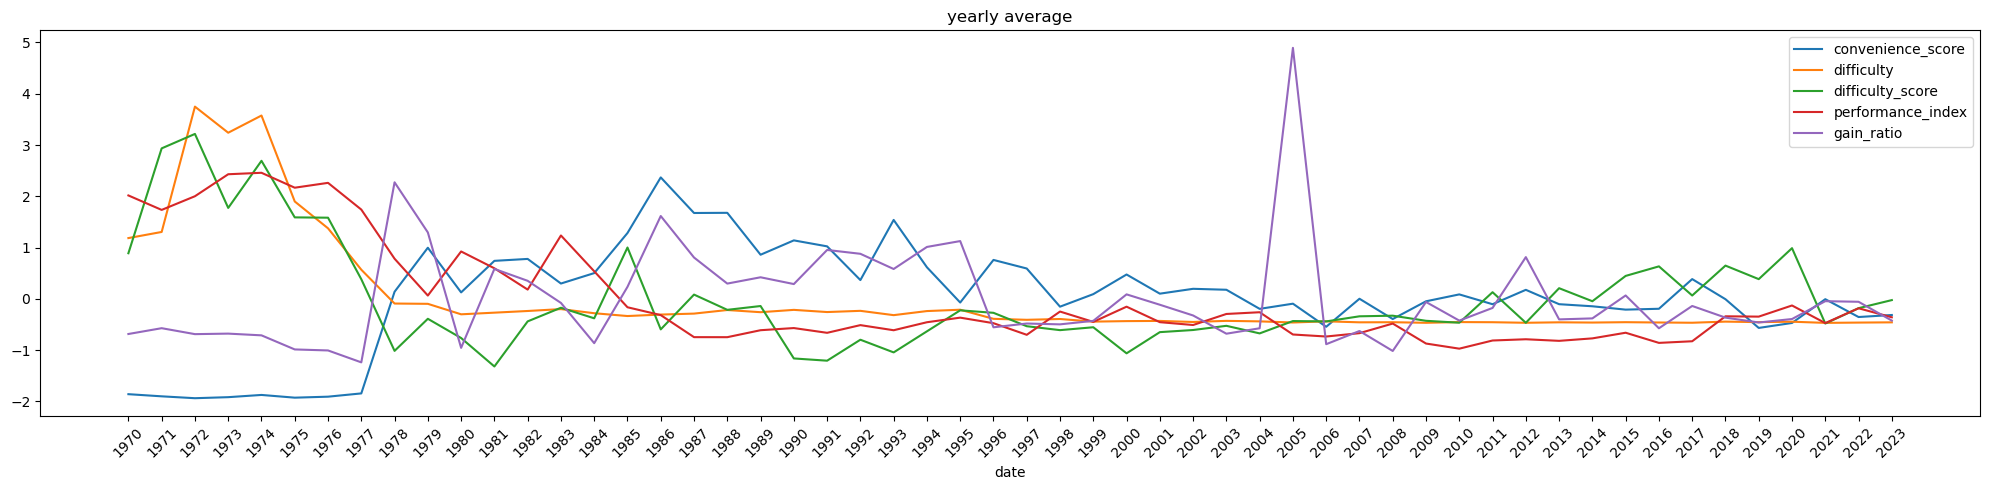

In [216]:
yearly_scores_mean_df=races_df.groupby([races_df.date.dt.year])[['convenience_score','difficulty','difficulty_score','performance_index','gain_ratio']].mean().sort_index()
yearly_scores_mean_df=(yearly_scores_mean_df- yearly_scores_mean_df.mean())/(yearly_scores_mean_df.std())
ax=yearly_scores_mean_df.plot(figsize=(20,5),title='yearly average')
ticks=ax.get_xticks()
ax.set_xticks(np.arange(1970,2024,step=1))
ax.set_xticklabels(map(int,ax.get_xticks()), rotation=45)
plt.tight_layout()
print()

Some interesint comments to do are
- the convenience score suddenly increases after 1977 along with gain ratio but then we get a saudden drop of the gain ratio while convenience score remains higher
- difficulty and difficulty_score are very similar and correlated and we can see that  the only difference istaht the difficulty is very stable after 1978 circa while the difficulty score tends to be much more unstable and diverges after the initial alignment.
- gain ratio also has a strange spike in 2005 and then returns to normal.

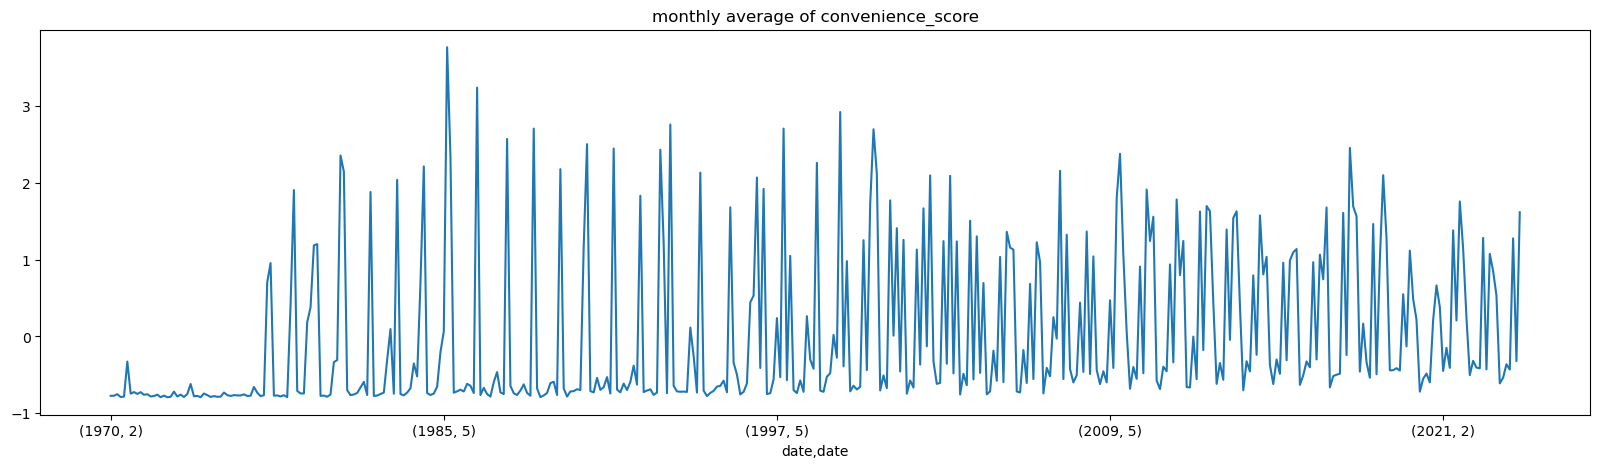

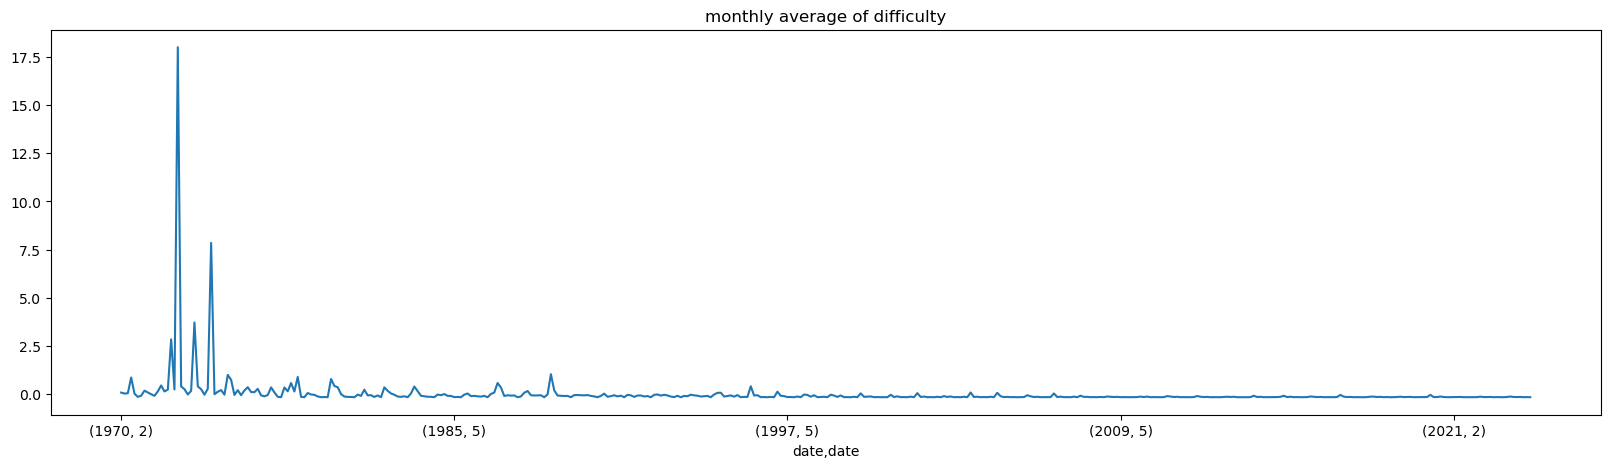

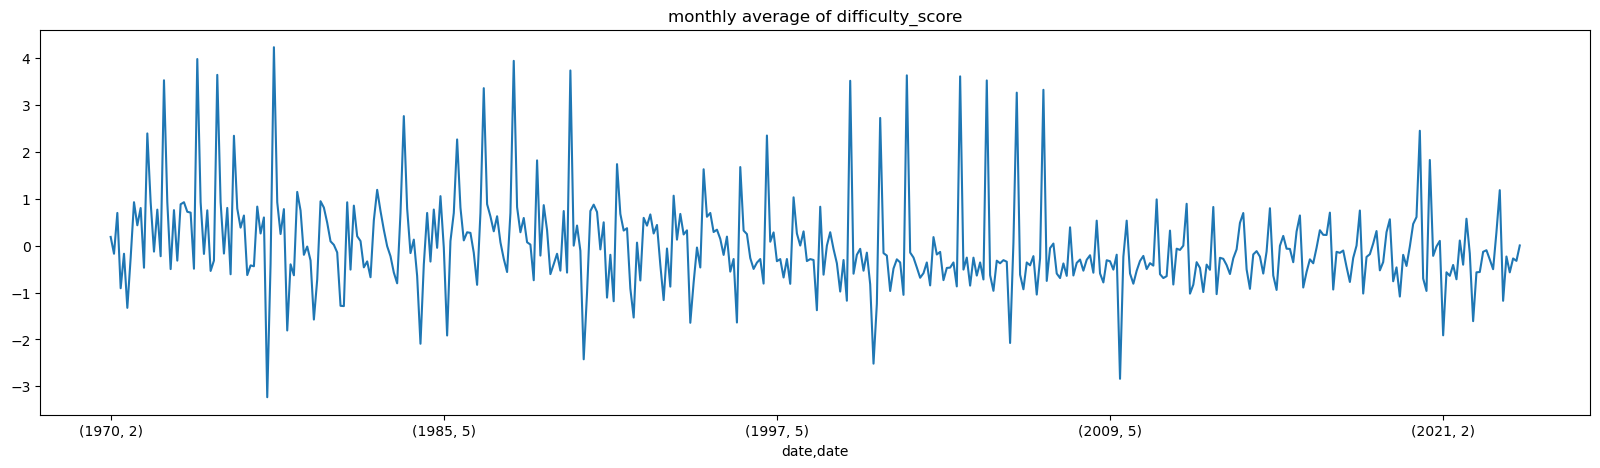

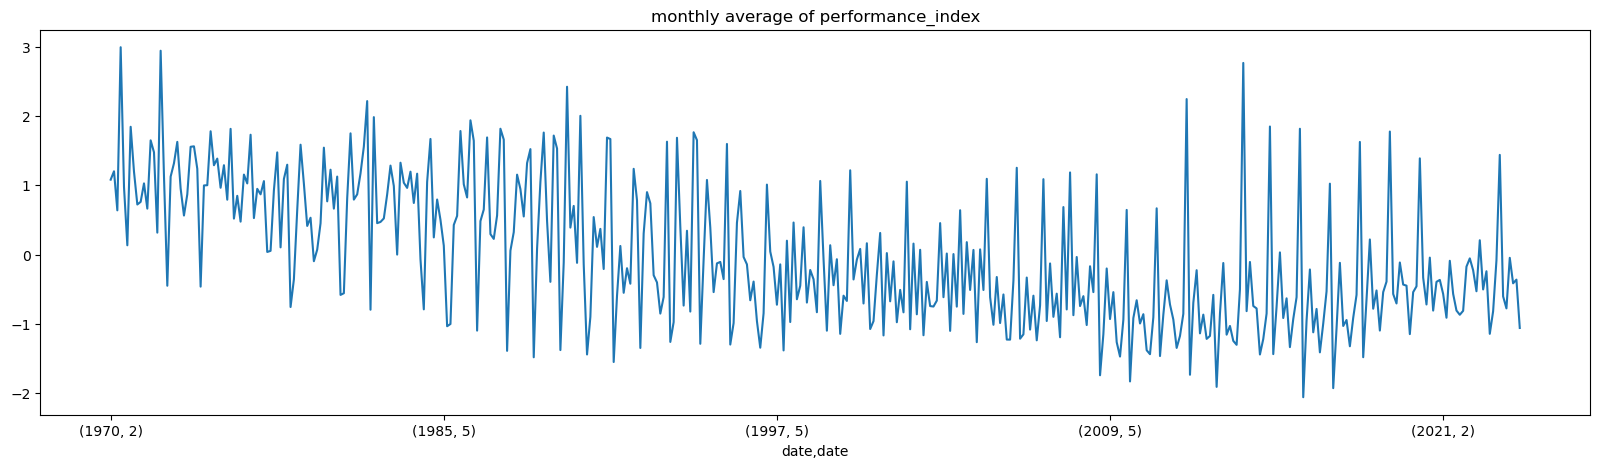

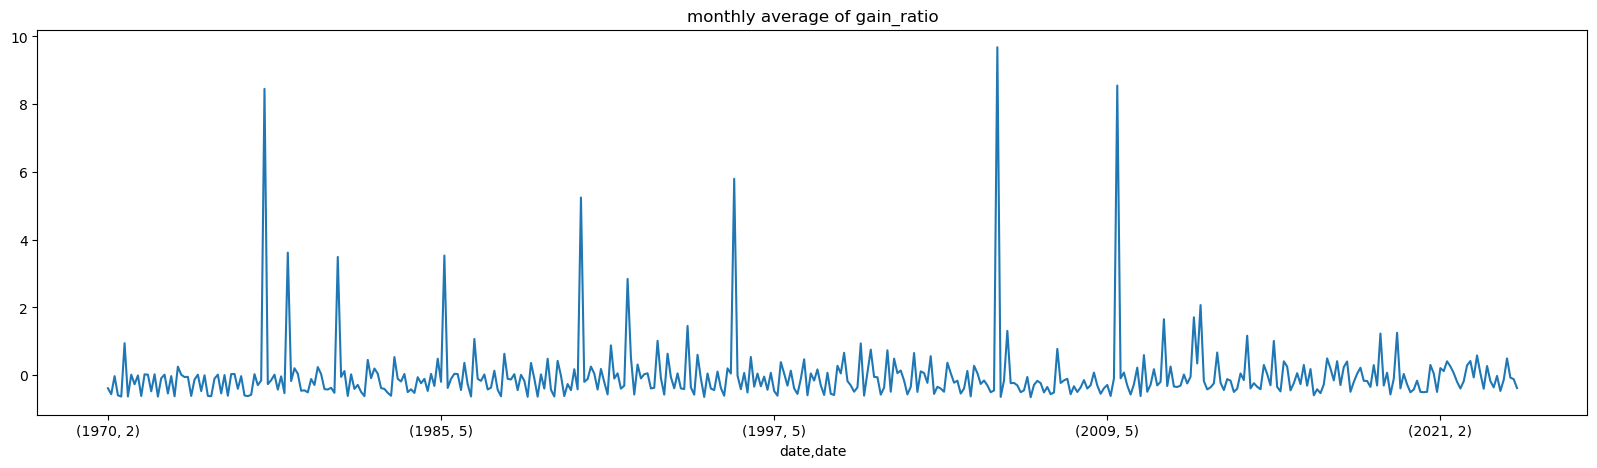

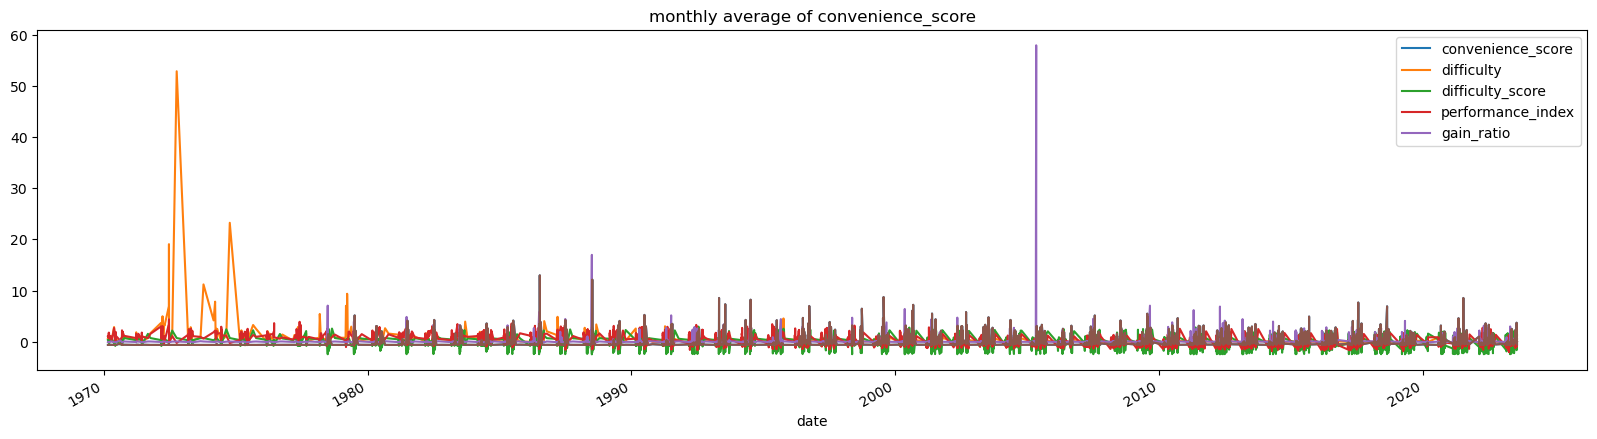

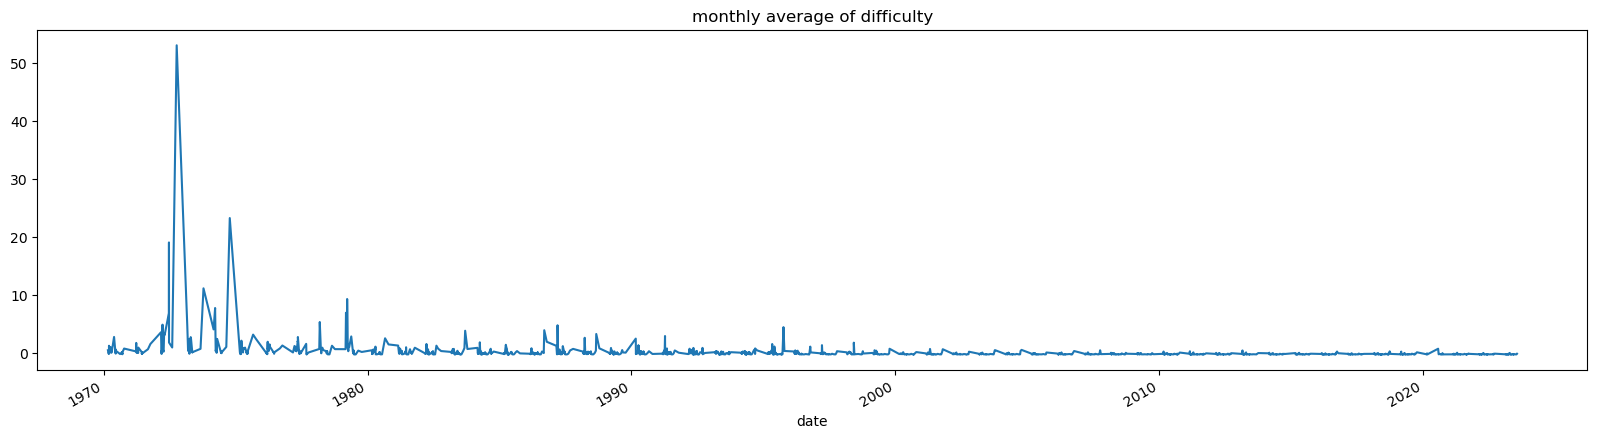

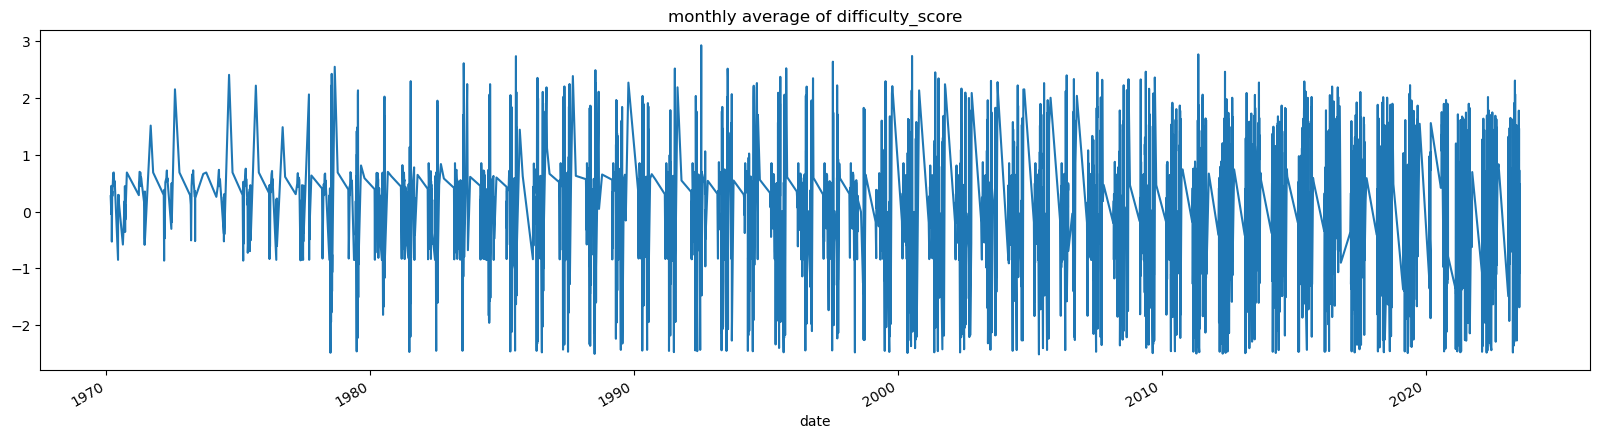

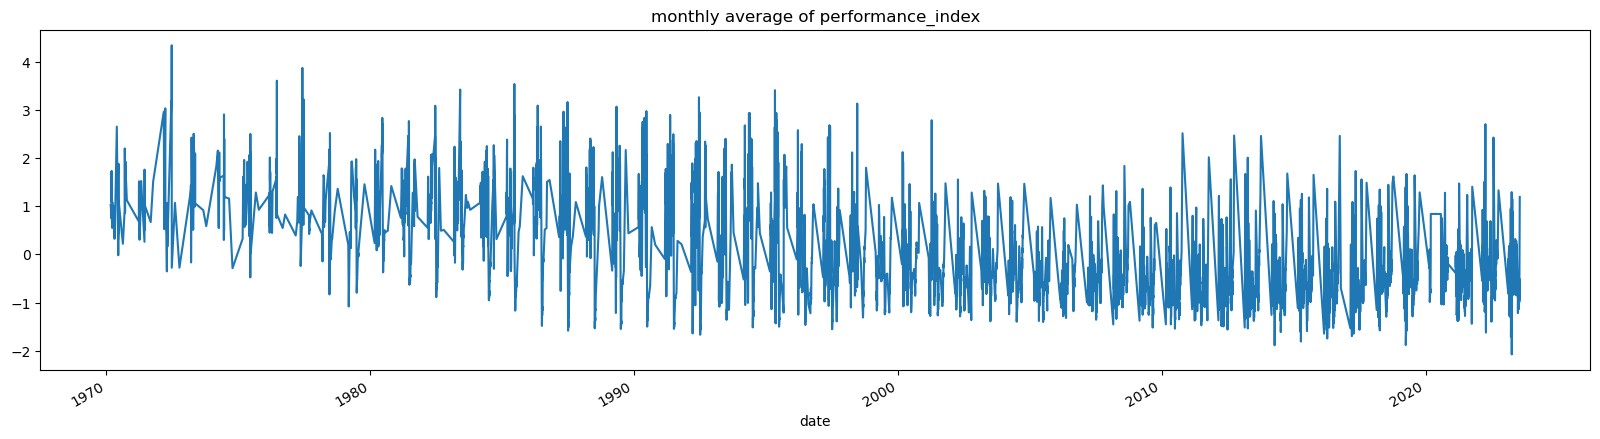

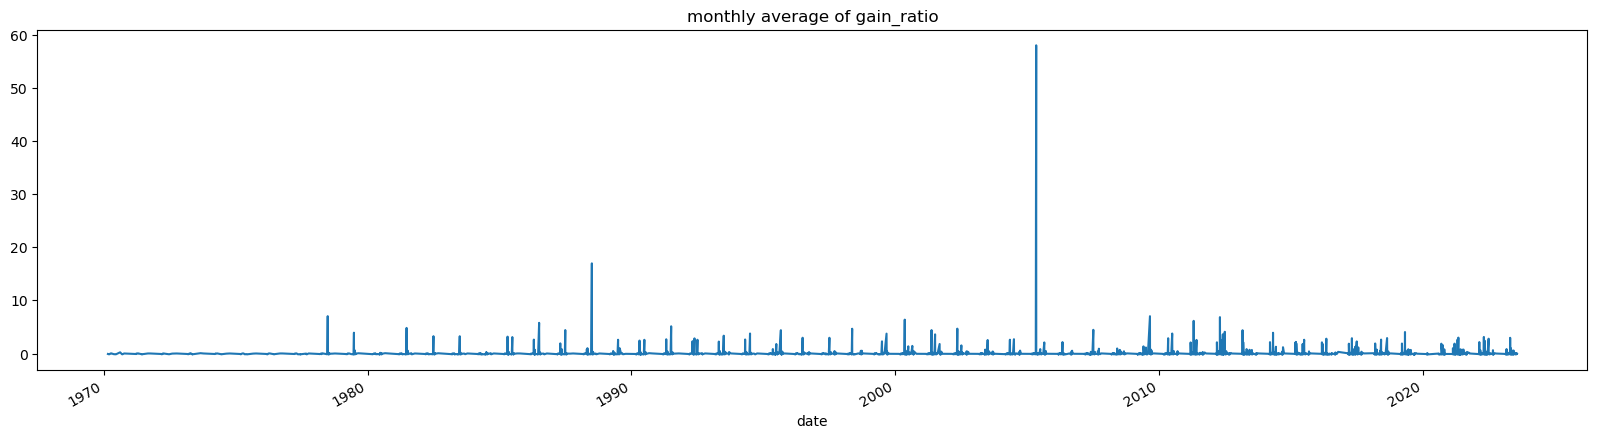

In [217]:
monthly_scores_mean_df=races_df.groupby([races_df.date.dt.year,races_df.date.dt.month])[['convenience_score','difficulty','difficulty_score','performance_index','gain_ratio']].mean().sort_index()
monthly_scores_mean_df=(monthly_scores_mean_df- monthly_scores_mean_df.mean())/(monthly_scores_mean_df.std())
for col in monthly_scores_mean_df.columns:
    monthly_scores_mean_df[col].plot(figsize=(20,5),title=f'monthly average of {col}')
    plt.show()


daily_scores_mean_df=races_df.groupby([races_df.date])[['convenience_score','difficulty','difficulty_score','performance_index','gain_ratio']].mean().sort_index()
daily_scores_mean_df=(daily_scores_mean_df- daily_scores_mean_df.mean())/(daily_scores_mean_df.std())
daily_scores_mean_df.plot(figsize=(20,5),title='daily average')
for col in daily_scores_mean_df.columns:
    daily_scores_mean_df[col].plot(figsize=(20,5),title=f'monthly average of {col}')
    plt.show()

As expected a comparison using monthly and yealry scales is difficult to make so we have to resort to other methods.

## seasonality

a nice idea would be to use cross correlation on the new features to find out any kind of seasonality.

In [218]:
def cross_correlation(data,x1,x2,lag,normalized=False):
  res=sum(data[x2].mul(data[x1].shift(-lag,fill_value=0)))
  if normalized:
    res/=np.sqrt(sum(data[x1]**2)*sum(data[x2]**2))
  return res

def ranged_crosscor(data,x1,x2,lag_abs_range,normalized=False):
  return [cross_correlation(data,x1,x2,l,normalized) for l in range(0,lag_abs_range)]
lag_range_abs=648#verify seasonality across seasons in months

crosscor_results=pd.DataFrame({
    'lag': range(lag_range_abs),
  }).set_index('lag')
for new_col in newf_df.columns:
    print(new_col)
    crosscor_results['result-'+new_col]=np.array(ranged_crosscor(monthly_scores_mean_df,'difficulty','difficulty',lag_range_abs,True))
    print(
       pd.concat([
       crosscor_results['result-'+new_col].sort_values(ascending=False)[1:6],
       crosscor_results['result-'+new_col].sort_values(ascending=False)[-5:],
       ]))



climbing_efficiency
lag
10     0.371153
5      0.275981
2      0.150354
12     0.072550
15     0.071550
368   -0.015801
347   -0.015872
346   -0.015939
355   -0.016065
356   -0.016160
Name: result-climbing_efficiency, dtype: float64
competitive_age
lag
10     0.371153
5      0.275981
2      0.150354
12     0.072550
15     0.071550
368   -0.015801
347   -0.015872
346   -0.015939
355   -0.016065
356   -0.016160
Name: result-competitive_age, dtype: float64
difficulty
lag
10     0.371153
5      0.275981
2      0.150354
12     0.072550
15     0.071550
368   -0.015801
347   -0.015872
346   -0.015939
355   -0.016065
356   -0.016160
Name: result-difficulty, dtype: float64
convenience_score
lag
10     0.371153
5      0.275981
2      0.150354
12     0.072550
15     0.071550
368   -0.015801
347   -0.015872
346   -0.015939
355   -0.016065
356   -0.016160
Name: result-convenience_score, dtype: float64
difficulty_score
lag
10     0.371153
5      0.275981
2      0.150354
12     0.072550
15     0.0715

Remembering that this is a monthly averaged graph we see that a time lag of 10 is always the max meaning we have some low repetition of trends every ten months roughly across all features. It sounds strange, we expected some repetition across season like winter,summer,spring etc.etc. however it doesn't seem to be the case here, further investigations should be done to understand if it is a coincidence or not.

Note: might be useful to try this on older features also since it was note done in the previous analysis.

Note: using fft we could also try to clean the noise from the time series/signal and try this approach on a daily averaged time series.

## sequentiality analysis

given the sequential nature of the dataset it is due an analysis to mine frequent sequential patterns.

first we need to switch to a transaction dataset to apply the algorithms.

for the numerical values discretization is needed, we first check the scales and values ditributions.

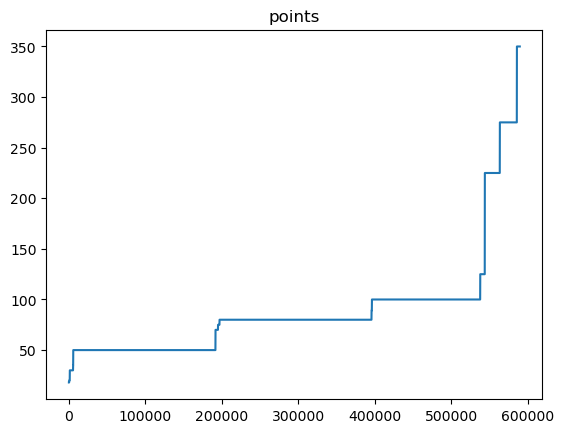

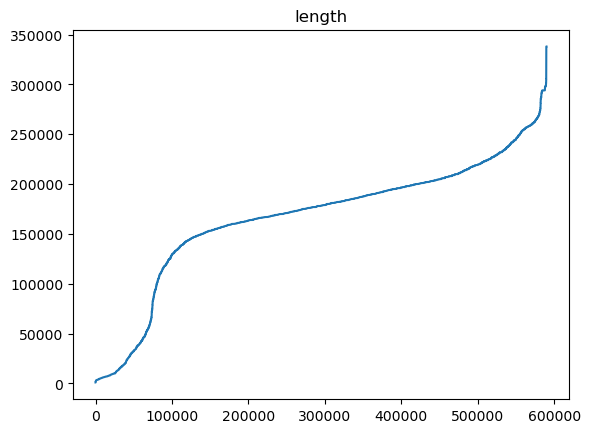

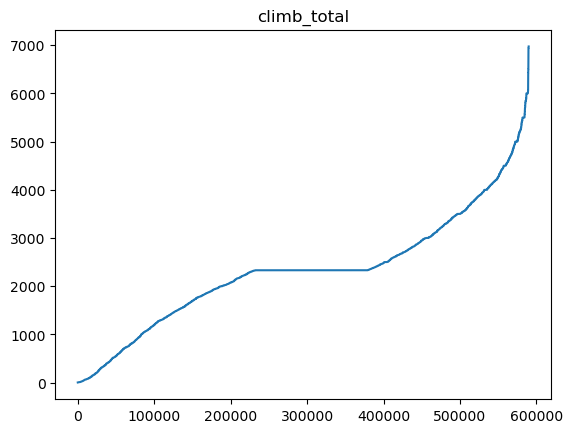

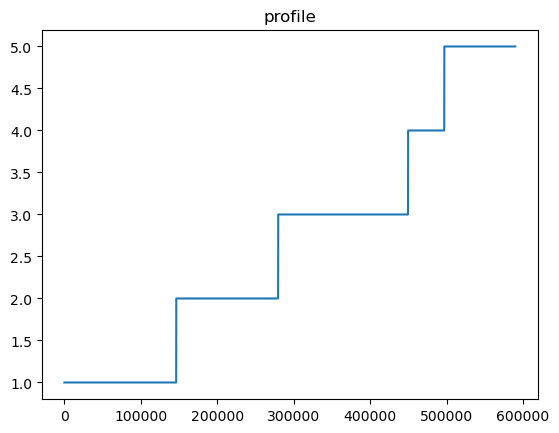

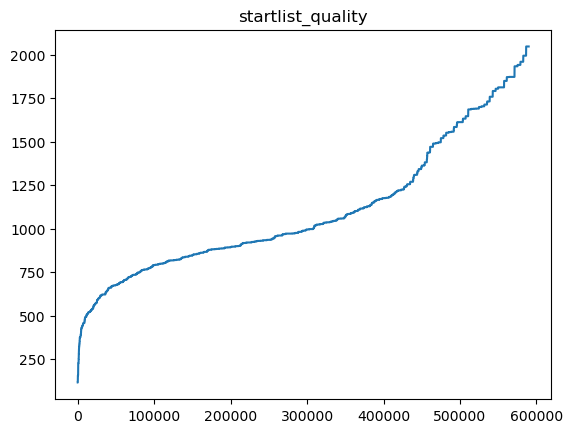

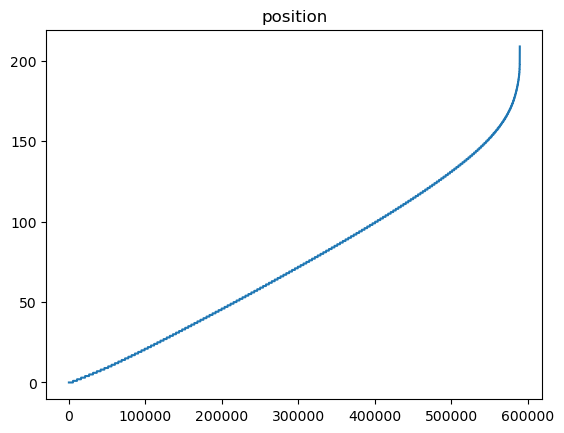

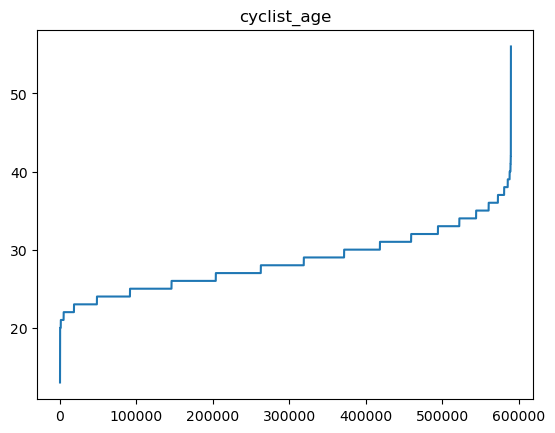

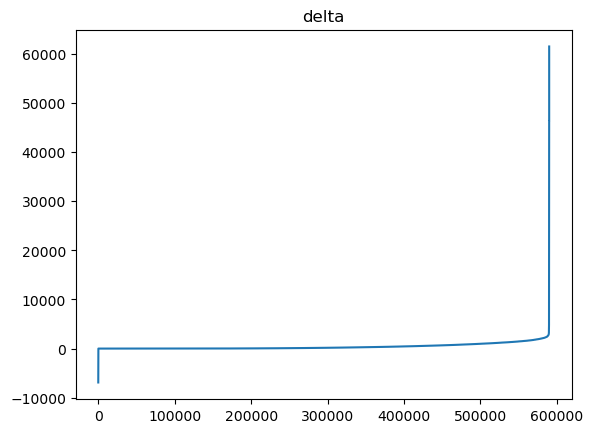

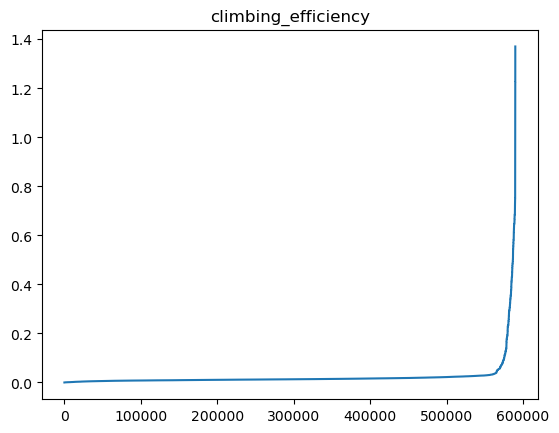

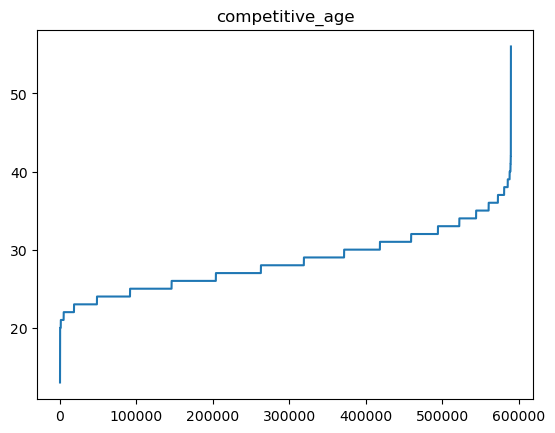

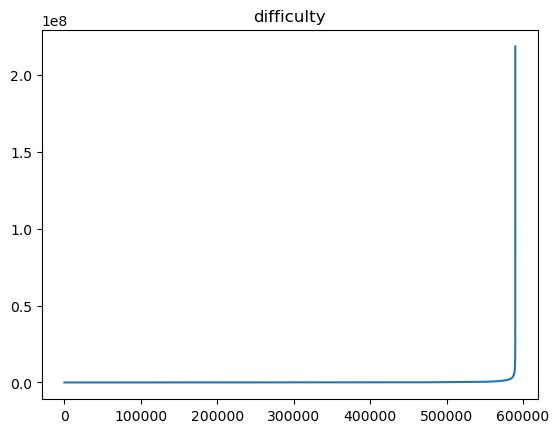

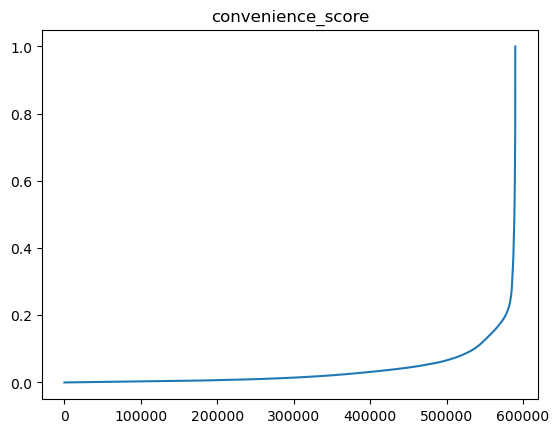

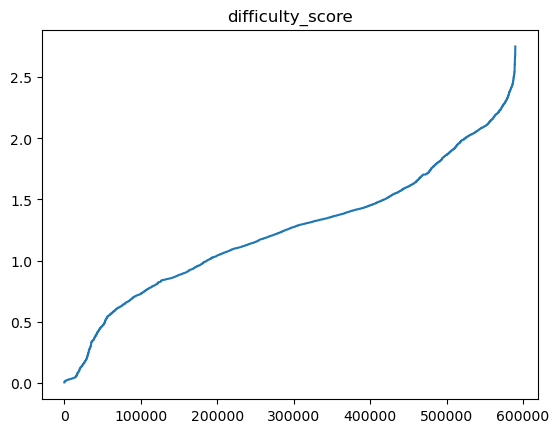

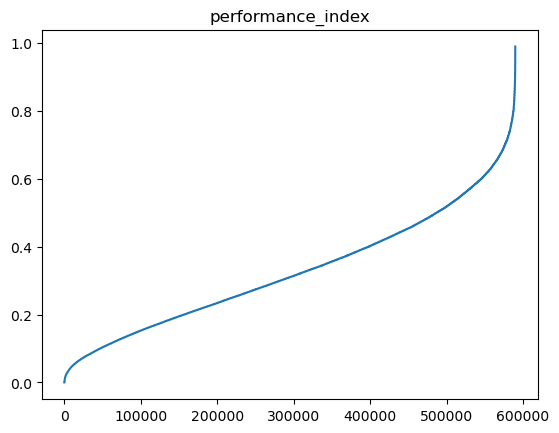

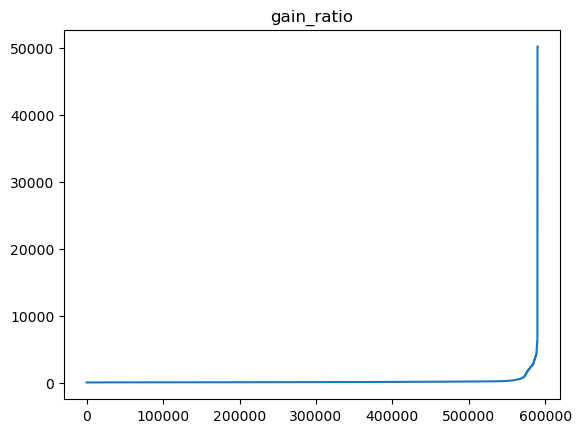

In [219]:
#determine data types from the dataset
seq_df=races_df.astype({
    categorical_column: "category" 
    for categorical_column in races_df.select_dtypes(include=["object","bool"])
})
num_cols=races_df.select_dtypes(include=["number"]).columns
for n_col in num_cols:
    plt.title(n_col)
    races_df[n_col].sort_values().reset_index()[n_col].plot()
    plt.show()

From this series of plot we can work in an ordered manner:
- for "stairs-like" distributions we can just discretize and create an ordinal value
- for "exponentials like"/long-tailed distributions it sounds reasonable to try binary quantization
- for the remaining types an approach based on decision trees to find out a reasonable way of binning sounds more correct.

We can start from stairs like distributions

In [220]:
stair_cols={
    'points':races_df['points'].unique(),
    'profile':['flat_1','flat_2','hilly','mountainous','high_mountains'],
    'cyclist_age':races_df['cyclist_age'].unique(),
    'competitive_age':['U16','U23','elite','masters_30-40','masters_41-45','elder masters'],
}
seq_df['competitive_age']=pd.cut(
    x=races_df['competitive_age'],
    bins=[12,13,19,23,30,40,45],
    labels=stair_cols['competitive_age']
    )

seq_df['points']=seq_df['points'].astype(int).astype(str)

seq_df['profile']=seq_df['profile'].apply(lambda x:stair_cols['profile'][int(x-1)])

seq_df['cyclist_age']=seq_df['cyclist_age'].astype(int).astype(str)


for the competitive age reasonable is based on age categories, the categories are drawn from [here](https://www.wpcycling.com/mtb/age-categories/).

for the profile it sounds reasonable to use the previous analysis done in the features engineering.

For long tailed distributions we have to check if the binary division is very neat or if we have only different scales created by strange outliers.


In [ ]:
import itertools as it
long_tail_cols=['delta','climbing_efficency','difficulty','convenience_score','gain_ratio']

sec_freq=10

min_freq=10

hour_freq=3600

seq_df['delta']=pd.cut(
    x=races_df['delta'].sort_values(),
    bins=list(
        it.chain(
            range(0,10,1),
            range(10,60,sec_freq),# bin every 10 seconds
            range(60,3600,60*min_freq),# bin every 10 minutes in an hour
            range(3600,int(races_df['delta'].max())+1,hour_freq)# bin every hour
        ))
)

for the deltas we discretized according to the needed precision and importance:
- the firs 10 seconds are very important we discretize every seconds
- the first minute is discretized every 10 seconds
- the first hour is discretized every 10 minutes
- for the hours we just bin every hour

Values are all within scale maybe a quantile based approach is more sound, this can be used to also give a textual name to the efficiencies.

In [222]:

seq_df['climbing_efficiency']=pd.qcut(
    x=seq_df['climbing_efficiency'],
    q=7,
    labels=['very slow','slow','slow-medium','medium','medium-fast','fast','very fast']
    )

difficulkty varies a lot in scale thus we decided to use scales has a measure for level of difficulty.

In [223]:
seq_df['difficulty']=pd.cut(
    x=seq_df['difficulty'],
    bins=[
        1000,
        10000,
        100000,
        1000000,
        10000000,
        100000000,
    ],
    labels=['very easy','easy','medium','hard','very hard']
)

Here we have same scale so we can discritize using the same reasoning as for the climbing efficienecy

In [224]:
seq_df['convenience_score']=pd.qcut(
    x=races_df['convenience_score'],
    q=10,
    labels=list(map(str,range(1,11)))
    )


the position becomes less important has it goes up so a wise approach is to discretize the first 10 position then use the first 50,100,150,200 positions.

In [225]:
seq_df['position']=pd.cut(
        x=races_df['position'],
        bins=[0,1,2,3,4,5,6,7,8,9,10,50,100,150,200],
        labels=list(it.chain(
            range(1,11),
            ["10 to 50","50 to 100","100 to 150","150 to 200"]
            )
        )
    )


length is not distributed according to a long-tailed distribution, there are multiple ways of classifyingraces depending on their type and length, as shown [here](https://en.wikipedia.org/wiki/UCI_race_classifications). 

Here we can take KM as a measure and since we havce 350000 meters we can scale down to 350 kilometers and bin with those.

In [226]:
seq_df['length']=pd.cut(
    x=races_df['length'],
    bins=np.array([0,10,20,30,40,50,100,150,200,250,300,350])*1000,
    labels=list(map(lambda x:f"{x[0]} to {x[1]}",
                    it.pairwise([0,10,20,30,40,50,100,150,200,250,300,350])
                ))
)


Note: there might be very distinct classification according to the domain however it really depends on the race,the type and the length we basically have different cateogires mixed as some might be very long multipleday races and some last one day or two and they can be of different types even if the time length is the same so to avoid confusion or strange biases we decoded to be a little more precise in the range 0 to 50 and the go with a coarse grained approach with a jump 50km each while defining the bins.

climb totals are all in the same scale thus we can just group using logic.
Note: from 5000 to 7000 is used because otherwise we get 

<Axes: xlabel='climb_total'>

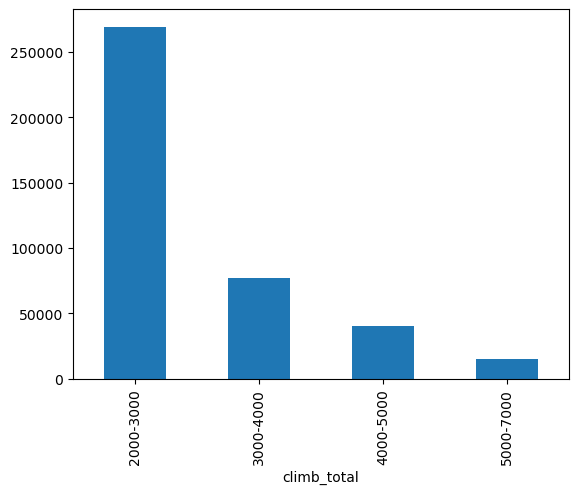

In [ ]:
seq_df['climb_total']=pd.cut(
    x=races_df['climb_total'].sort_values(),
    bins=[
        2000,
        3000,
        4000,
        5000,
        7000
        ],
    labels=[
        '2000-3000',
        '3000-4000',
        '4000-5000',
        '5000-7000'
    ]
    ).value_counts().plot(kind='bar')

Note: review this binning otherwise you might get heavily biased results.

here there are no issues all values are in the same range more or less, just use quantiles.

<Axes: xlabel='startlist_quality'>

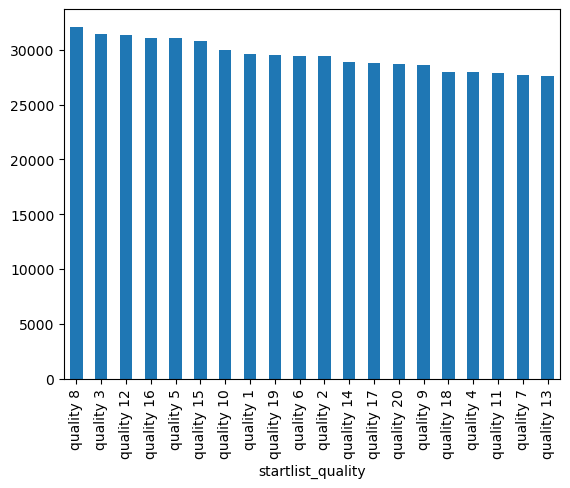

In [ ]:
seq_df['startlist_quality']=pd.qcut(
    x=races_df['startlist_quality'],
    q=20,
    labels=list(map(
        lambda x: f"quality {x}",
        range(1,21)
    ))
)


Same goes here

In [259]:
seq_df['startlist_quality']=pd.qcut(
    x=races_df['startlist_quality'],
    q=5,
    labels=list(map(
        lambda x: f"difficulty {x}",
        range(1,6)
    ))
)

<Axes: xlabel='gain_ratio'>

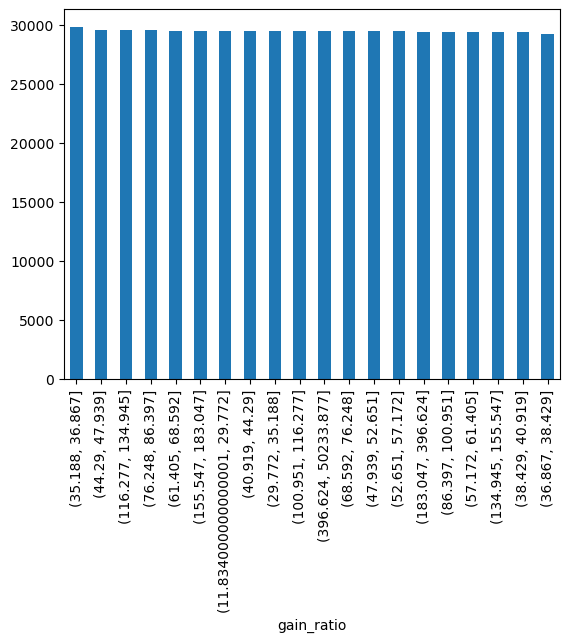

In [ ]:
seq_df['gain_ratio']=pd.qcut(
    x=races_df['gain_ratio'],
    q=20,
).value_counts().plot(kind='bar')